In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.ensemble import GradientBoostingClassifier as gboost, RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_squared_error,
                             classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve)

from sklearn.preprocessing import LabelEncoder

from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
from keras.layers.merge import _Merge
from keras import backend as K
from keras.models import load_model
from functools import partial

pd.options.display.max_rows = 4000

BATCH_SIZE = 1024

#Defining functions 

def scalex(X):
    """ normalize between 0 and 1 the values in X """
    nmin, nmax = 0.0, 1.0
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (nmax - nmin) + nmin
    return X_scaled
#
# Last card of scalex.
#
def calcrmse(X_train, gensamples):
    """ compute mse for training """
    max_column = X_train.shape[1]
    rmse_lst = []
    for col in range(max_column):
        rmse_lst.append(np.sqrt(mean_squared_error(X_train[:,col], gensamples[:,col])))
    return np.sum(rmse_lst) / max_column
#
# Last card of calcrmse.
#
def wasserstein_loss(y_true, y_pred):
    """ Wasserstein distance """
    return K.mean(y_true * y_pred)
#
# Last card of wasserstein_loss.
#
def gradient_penalty_loss(y_true, y_pred, averaged_samples, lamba_reg):
    """ compute gradient penalty loss for GP-WGAN """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = lamba_reg * K.square(1 - gradient_l2_norm)
    return K.mean(gradient_penalty)
#
# Last card of gradient_penalty_loss.
#
class RandomWeightedAverage(_Merge):
    def _merge_function(self, inputs):
        weights = K.random_uniform((BATCH_SIZE, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
#
# Last card of RandomWeightedAverage.
#
def generate_samples(generator_model, noise_dim, num_samples):
    """ generate samples to be used for futher analysis """
    return generator_model.predict(np.random.rand(num_samples, noise_dim))

def kill_empty_first(df):
    for column in df.columns:
        unique_values = np.unique(df[column])
        if len(unique_values) > 1:
            print(f"Column '{column}' has different values.")
        else:
            print(f"Column '{column}' has the same value in all rows.")
            df.drop(column, axis=1, inplace=True)


def create_normalized_dataframe(df, attack_name):
    df_new = df.loc[df[" Label"] == attack_name]

    features = []
    for n in range(len(lbl)-1):
        m = lbl[n]
        tmp = np.unique(df_new[m])
        if (len(tmp) > 1):
            features.append(m)

    # normalize each field independently
    df_attack_norm = df_new
    for n in range(len(lbl)-1):
        m = lbl[n]
        if (np.max(df_attack_norm[m]) > 1).any(): 
            if (len(np.unique(df_attack_norm[m])) > 1):
                df_attack_norm[m] = scalex(df_attack_norm[m])
            else:
                df_attack_norm[m] = np.int64(1)  

    return df_attack_norm

def kill_empty(df):
    for column in df.columns[:-1]:
        unique_values = np.unique(df[column])
        if len(unique_values) > 1:
            print(f"Column '{column}' has different values.")
        else:
            print(f"Column '{column}' has the same value in all rows.")
            df.drop(column, axis=1, inplace=True)

    return df

df = pd.read_csv('./data/MachineLearningCVE/Tuesday-workingHours.pcap_ISCX.csv', sep=",", header=None, low_memory=False)

df = df.dropna()

df.columns = df.iloc[0]
df = df[1:]

df = df.apply(pd.to_numeric, errors='ignore')

#kill_empty_first(df)

label_counts = df[' Label'].value_counts()
print(label_counts)

lbl = df.columns

print(df.isna().sum())

Using TensorFlow backend.
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)

BENIGN         431873
FTP-Patator      7938
SSH-Patator      5897
Name:  Label, dtype: int64
0
 Destination Port               0
 Flow Duration                  0
 Total Fwd Packets              0
 Total Backward Packets         0
Total Length of Fwd Packets     0
 Total Length of Bwd Packets    0
 Fwd Packet Length Max          0
 Fwd Packet Length Min          0
 Fwd Packet Length Mean         0
 Fwd Packet Length Std          0
Bwd Packet Length Max           0
 Bwd Packet Length Min          0
 Bwd Packet Length Mean         0
 Bwd Packet Length Std          0
Flow Bytes/s                    0
 Flow Packets/s                 0
 Flow IAT Mean                  0
 Flow IAT Std                   0
 Flow IAT Max                   0
 Flow IAT Min                   0
Fwd IAT Total                   0
 Fwd IAT Mean                   0
 Fwd IAT Std                    0
 Fwd IAT Max                    0
 Fwd IAT Min                    0
Bwd IAT Total                   0
 Bwd IAT Mean        

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

#attack_name = "DoS slowloris"
#attack_name = "DoS Hulk"
attack_name = "SSH-Patator"
#attack_name = "DoS GoldenEye"
#attack_name = "FTP-Patator"
df_attack_norm = create_normalized_dataframe(df, attack_name)
#df_normal_norm = create_normalized_dataframe(df, "BENIGN")
#df_attack_norm = kill_empty(df_attack_norm)
df_attack_norm = df_attack_norm.dropna()
print(df_attack_norm)


# build GP-WGAN and generate adversarial samples
#
BATCH_SIZE = 1024

GRADIENT_PENALTY_WEIGHT = 10 #0.1
MAX_SIM = 5897 #10293 #10000
X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
np.random.shuffle(X_train)
#df_attack_norm.to_csv('output.csv', index=False)
#
MAX_EPOCH = 8000 #15000 6500
TRAINING_RATIO = 3
#
NUM_SAMPLES = 2000 #5000
#
### Building the model
def make_generator(noise_dim):
    model = Sequential()
    model.add(Dense(256,  kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128,  kernel_initializer='he_normal'))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=noise_dim, activation='linear'))
    return model
#
#    Last card of make_generator.
#    
def make_discriminator():
    model = Sequential()
    model.add(Dense(256, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(128, kernel_initializer='he_normal', input_dim=INPUT_DIM))
    model.add(Activation('relu')) # model.add(Activation('relu'))
    model.add(Dense(units=1, activation='linear'))
    return model
#
#    Last card of make_discriminator.
#
print("current_gradpenalty:", GRADIENT_PENALTY_WEIGHT)

INPUT_DIM = X_train.shape[1]
noise_dim = INPUT_DIM

generator = make_generator(noise_dim)
discriminator = make_discriminator()


#### for the generator it is mostly the same as WGAN std
for layer in discriminator.layers:
    layer.trainable = False
discriminator.trainable = False

generator_input = Input(shape=(noise_dim,))
generator_layers = generator(generator_input)
discriminator_layers_for_generator = discriminator(generator_layers)

generator_model = Model(inputs=[generator_input], outputs=[discriminator_layers_for_generator])
generator_model.compile(optimizer=RMSprop(lr = 0.005, rho = 0.9, epsilon=1e-6), loss = wasserstein_loss)
#enerator_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)


#### New discriminator model for GPWGAN
for layer in discriminator.layers:
    layer.trainable = True
for layer in generator.layers:
    layer.trainable = False
discriminator.trainable = True
generator.trainable = False 


real_samples = Input(shape=X_train.shape[1:])
generator_input_for_discriminator = Input(shape=(noise_dim,))
generated_samples_for_discriminator = generator(generator_input_for_discriminator)
discriminator_output_from_generator = discriminator(generated_samples_for_discriminator)
discriminator_output_from_real_samples = discriminator(real_samples)

averaged_samples = RandomWeightedAverage()([real_samples, generated_samples_for_discriminator])
averaged_samples_out = discriminator(averaged_samples)

discriminator_model = Model(inputs=[real_samples, generator_input_for_discriminator], 
                            outputs=[discriminator_output_from_real_samples, discriminator_output_from_generator, 
                                     averaged_samples_out])


### the loss function takes more inputs than the standard y_true and y_pred 
### values usually required for a loss function. Therefore, we will make it partial.
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_samples, lamba_reg=GRADIENT_PENALTY_WEIGHT)
partial_gp_loss.__name__ = 'gp_loss' 


# finally, we compile the model
#discriminator_model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-6), loss=wasserstein_loss)
discriminator_model.compile(optimizer=RMSprop(lr=0.005, rho=0.9, epsilon=1e-6), loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss])
#discriminator_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5, beta_2=0.9), loss=wasserstein_loss)



positive_y = np.ones((BATCH_SIZE, 1), dtype=np.float32)
negative_y = -positive_y
dummy_y = np.zeros((BATCH_SIZE, 1), dtype=np.float32) # dummy vector mandatory for the train on batch function

for epoch in range(MAX_EPOCH + 1):
    np.random.shuffle(X_train)

    minibatches_size = BATCH_SIZE * TRAINING_RATIO
    for i in range(int(X_train.shape[0] // (BATCH_SIZE * TRAINING_RATIO))):
        discriminator_minibatches = X_train[i * minibatches_size:(i + 1) * minibatches_size]
        for j in range(TRAINING_RATIO):
            sample_batch = discriminator_minibatches[j * BATCH_SIZE:(j + 1) * BATCH_SIZE]
            noise = np.random.rand(BATCH_SIZE, noise_dim).astype(np.float32)

            discriminator_model.train_on_batch([sample_batch, noise], [positive_y, negative_y, dummy_y])

        generator_model.train_on_batch(np.random.rand(BATCH_SIZE, noise_dim), positive_y)


    #Visualization of intermediate results
    if (epoch % 100 == 0):
        gensamples = generate_samples(generator, noise_dim, MAX_SIM)
        rmse_sofar = calcrmse(X_train, gensamples)
        print("Epoch: ", epoch, "\t", "rmse: ", rmse_sofar)

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        Destination Port   Flow Duration   Total Fwd Packets  \
161990                  1        0.000003             0.03125   
161991                  1        0.048481             0.43750   
162052                  1        0.048747             0.53125   
162053                  1        0.048382             0.50000   
162054                  1        0.048215             0.43750   
...                   ...             ...                 ...   
445685                  1        0.113587             0.65625   
445689                  1        0.113956             0.65625   
445690                  1        0.114185             0.65625   
445815                  1        0.113720             0.65625   
445818                  1        0.113942             0.65625   

0        Total Backward Packets  Total Length of Fwd Packets  \
161990                 0.000000                     0.000000   
161991                 0.418605                     0.390397   
162052                 0.44

In [ ]:
#generator.save('Good_generator.h5')
#discriminator.save('Good_discriminator.h5')
#generator_model.save('Good_generator_model.h5')
#discriminator_model.save('Good_discriminator_model.h5')

#attack_name = "SSH-Patator"
#df_attack_norm = create_normalized_dataframe(df, attack_name)
#df_attack_norm = df_attack_norm.dropna()

#MAX_SIM = 5897 #10293 #10000

#X_train = np.asarray(df_attack_norm.iloc[:MAX_SIM, :-1])
#np.random.shuffle(X_train)

#noise_dim = X_train.shape[1]


#generator = load_model('Good_generator.h5')
#discriminator = load_model('Good_discriminator.h5')

In [5]:
generated_samples=generate_samples(generator, noise_dim, MAX_SIM)

df_generated_samples = pd.DataFrame(generated_samples)

df_original = df_attack_norm.iloc[:MAX_SIM, :-1]

df_generated_samples.columns = df_original.columns

print(df_generated_samples)

unique_samples = np.unique(df_generated_samples, axis=0)
print(f"Number of unique samples: {len(unique_samples)}")

unique_samples_original = np.unique(df_original, axis=0)
print(f"Number of unique samples in original data: {len(unique_samples_original)}")

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* com

0      Destination Port   Flow Duration   Total Fwd Packets  \
0              1.019572       -0.005363            0.000402   
1              1.019026       -0.005265            0.000532   
2              1.025959        0.114333            0.641050   
3              1.019488        0.115046            0.637640   
4              1.012121       -0.004026            0.002176   
...                 ...             ...                 ...   
5892           1.024830       -0.006307           -0.000851   
5893           1.010900       -0.003807            0.002467   
5894           0.998765        0.134890            0.718927   
5895           0.970651       -0.001486            0.006140   
5896           0.998989       -0.001670            0.005304   

0      Total Backward Packets  Total Length of Fwd Packets  \
0                    0.032030                     0.003711   
1                    0.031897                     0.003751   
2                    0.732466                     0.55004

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Column ' Destination Port' has the same value in all rows.
Column ' Flow Duration' has different values.
Column ' Total Fwd Packets' has different values.
Column ' Total Backward Packets' has different values.
Column 'Total Length of Fwd Packets' has different values.
Column ' Total Length of Bwd Packets' has different values.
Column ' Fwd Packet Length Max' has different values.
Column ' Fwd Packet Length Min' has different values.
Column ' Fwd Packet Length Mean' has different values.
Column ' Fwd Packet Length Std' has different values.
Column 'Bwd Packet Length Max' has different values.
Column ' Bwd Packet Length Min' has the same value in all rows.
Column ' Bwd Packet Length Mean' has different values.
Column ' Bwd Packet Length Std' has different values.
Column 'Flow Bytes/s' has different values.
Column ' Flow Packets/s' has different values.
Column ' Flow IAT Mean' has different values.
Column ' Flow IAT Std' has different values.
Column ' Flow IAT Max' has different values.
C

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Column ' Fwd Packet Length Mean' has different values.
Column ' Fwd Packet Length Std' has different values.
Column 'Bwd Packet Length Max' has different values.
Column ' Bwd Packet Length Min' has different values.
Column ' Bwd Packet Length Mean' has different values.
Column ' Bwd Packet Length Std' has different values.
Column 'Flow Bytes/s' has the same value in all rows.
Column ' Flow Packets/s' has the same value in all rows.
Column ' Flow IAT Mean' has different values.
Column ' Flow IAT Std' has different values.
Column ' Flow IAT Max' has different values.
Column ' Flow IAT Min' has different values.
Column 'Fwd IAT Total' has different values.
Column ' Fwd IAT Mean' has different values.
Column ' Fwd IAT Std' has different values.
Column ' Fwd IAT Max' has different values.
Column ' Fwd IAT Min' has different values.
Column 'Bwd IAT Total' has different values.
Column ' Bwd IAT Mean' has different values.
Column ' Bwd IAT Std' has different values.
Column ' Bwd IAT Max' has d

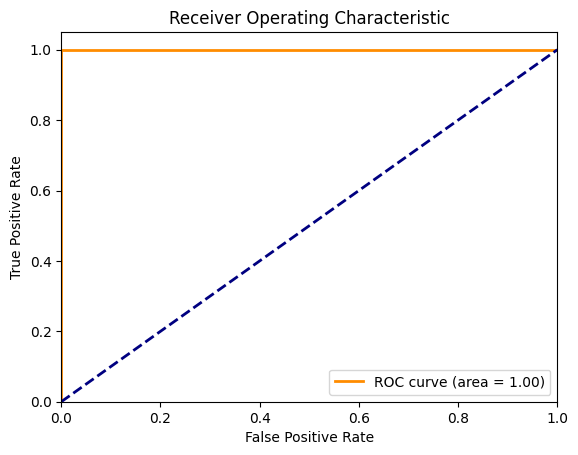

In [8]:
#Classification between benign and attack traffic

num_rows = 5000
attack_name = "SSH-Patator"
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()

df_attack_norm = kill_empty(df_attack_norm) #Gets rid of columns that have the same value in all rows.
df_benign_norm = kill_empty(df_benign_norm)

# Find the difference in columns
diff_columns = df_benign_norm.columns.difference(df_attack_norm.columns)

# Drop the extra columns from df1
df_benign_norm = df_benign_norm.drop(columns=diff_columns)

# Find the difference in columns
diff_columns = df_attack_norm.columns.difference(df_benign_norm.columns)

# Drop the extra columns from df1
df_attack_norm = df_attack_norm.drop(columns=diff_columns)

combined_df = pd.concat([df_attack_norm[:num_rows], df_benign_norm[:num_rows]])
combined_df = combined_df.sample(frac=1)

y = combined_df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(combined_df.iloc[:,:-1], \
                                                    y, test_size=.2, random_state=42)


# Instantiate the encoder
le = LabelEncoder()

# Fit and transform the target variable
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


# Create a Random Forest classifier object
classifier = RandomForestClassifier()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5000
           1       1.00      0.99      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Confusion Matrix:
 [[5000    0]
 [  29 4971]]
Accuracy:  0.9971
ROC AUC:  0.9971


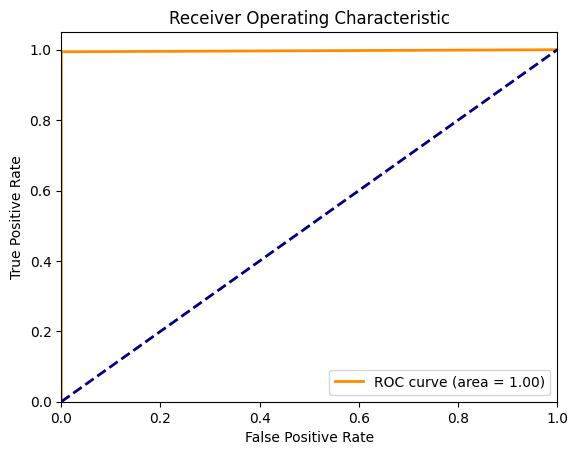

In [9]:
#Now training on generated and testing with real.

num_rows = 5000
num_train_rows = 5000
num_test_rows = 5000
attack_name = "SSH-Patator"
lbl = df.columns
df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_benign_norm = df_benign_norm.dropna()

#df_attack_norm = kill_empty(df_attack_norm)
#df_benign_norm = kill_empty(df_benign_norm)

#df_generated_samples = kill_empty(df_generated_samples)

df_generated_samples[' Label'] = "SSH-Patator"
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_train = pd.concat([df_gensamples_norm[:num_rows], df_benign_norm[:num_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
#df_test = pd.concat([df_attack_norm[:num_test_rows], df_benign_norm[:num_train_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = RandomForestClassifier()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\Timohin\Desktop\Folders\Uni stuff\Year3\Project\Project\.venv\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      2500

    accuracy                           1.00      7500
   macro avg       1.00      1.00      1.00      7500
weighted avg       1.00      1.00      1.00      7500

Confusion Matrix:
 [[5000    0]
 [   0 2500]]
Accuracy:  1.0
ROC AUC:  1.0


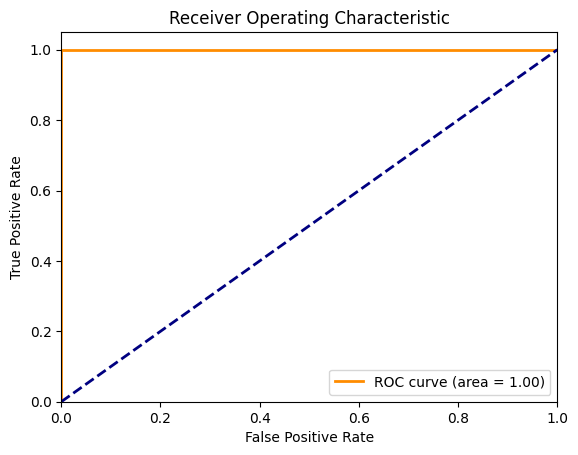

In [20]:
#Train with both.
#Test with real.
#Classifier between normal and attack data

num_train_rows = 5000
num_test_rows = 5000
num_test_rows_attack = 2500

gen_in_train = 2500
real_in_train = 2500

attack_name = "SSH-Patator"
df_generated_samples[' Label'] = "SSH-Patator"
lbl = df.columns

df_attack_norm = create_normalized_dataframe(df, attack_name)
df_benign_norm = create_normalized_dataframe(df, "BENIGN")
df_gensamples_norm = create_normalized_dataframe(df_generated_samples, attack_name)

df_benign_norm = df_benign_norm.dropna()

df_training_mix = pd.concat([df_attack_norm[:real_in_train], df_gensamples_norm[:gen_in_train]])

df_train = pd.concat([df_training_mix[:num_train_rows], df_benign_norm[:num_train_rows]])
df_train = df_train.sample(frac=1)

X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]


# Use original data for testing
df_test = pd.concat([df_attack_norm[real_in_train:real_in_train + num_test_rows_attack], df_benign_norm[num_train_rows:num_train_rows+num_test_rows]])
df_test = df_test.sample(frac=1)


X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


# Instantiate the encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Create a Random Forest classifier object
classifier = gboost()


# Fit the classifier on the training data
classifier.fit(X_train, y_train)

# Use the classifier to predict the labels for the test data
y_pred = classifier.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))


# Print the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Print the accuracy score
acc = accuracy_score(y_test, y_pred)
print("Accuracy: ", acc)

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC: ", roc_auc)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Train the classifier on the generated data

And feed the real data to it, see if it picks it up.

Train IDS on real data.
test with real.

Train on generated.
Test with real.

Train with both.
Test with real.

How useful is the generated data.
